### ROC CURVE and AUC

## I Introduction

ROC: Receiver Operating Characteristic curves and AUC: Area Under [the] Curve are two concept that repeatedly appear in a lot of machine learning problem. So what are they and why it is so important to know about them?

Let's take a look at the breast cancer data set below.

In [16]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

In [3]:
data = load_breast_cancer()

In [4]:
data.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [5]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [11]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

columns=data.feature_names
X=pd.DataFrame(data.data, columns=columns)
y=pd.DataFrame(data.target, columns=['Target'])
df=pd.concat([y,X],axis=1)

In [9]:
df.sample(5)

,Target,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
126,0,13.61,24.69,87.76,572.6,0.09258,0.07862,0.052850,0.030850,0.1761,...,16.89,35.64,113.20,848.7,0.14710,0.28840,0.37960,0.13290,0.3470,0.07900
272,0,21.75,20.99,147.30,1491.0,0.09401,0.19610,0.219500,0.108800,0.1721,...,28.19,28.18,195.90,2384.0,0.12720,0.47250,0.58070,0.18410,0.2833,0.08858
522,1,11.26,19.83,71.30,388.1,0.08511,0.04413,0.005067,0.005664,0.1637,...,11.93,26.43,76.38,435.9,0.11080,0.07723,0.02533,0.02832,0.2557,0.07613
387,1,13.88,16.16,88.37,596.6,0.07026,0.04831,0.020450,0.008507,0.1607,...,15.51,19.97,99.66,745.3,0.08484,0.12330,0.10910,0.04537,0.2542,0.06623
390,1,10.26,12.22,65.75,321.6,0.09996,0.07542,0.019230,0.019680,0.1800,...,11.38,15.65,73.23,394.5,0.13430,0.16500,0.08615,0.06696,0.2937,0.07722


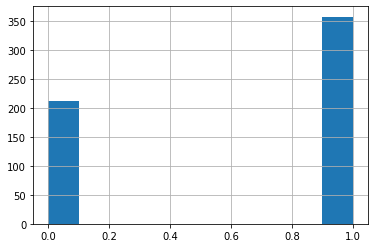

In [29]:
df.Target.hist()
plt.show()

Observe that this is a binary classification problem and the 2 classes are imbalanced. A sensible metric to evaluate your model is recall, where detecting 'malignant' cases is more emphasized than the detecting benigns cases. Is it enough?  If you are a patient and there are 40 percent chance that you have breast cancer (lower than random guess), how much confident would the doctor have when he says you do not have cancer?

To answer these question, you need some kind of system that can tell you the accuracy that emphasized more to the 'malignant' cases and also give you a good decision boundary to decide the result of the test. This is where ROC curve and AUC score shines



## II ROC CURVE

The Receiver Operator Characteristic curve (ROC curve) illustrates the true positive rate (TPR) against the false positive rate (FPR) of our classifier.

TPR before is just another name for **recall**!. Mathematically, the TPR is represented by:

$$ \text{TPR} = \frac{\text{TP}}{\text{TP}+\text{FN}} $$

Also, the FPR represented as:

$$ \text{FPR} = \frac{\text{FP}}{\text{FP}+\text{TN}}$$

Let's take another step back. Let's use logistic regression and applied to our model. Each observation with have a probability outcome (from 0 to 1), if we plot these out, we will obtain something like this:


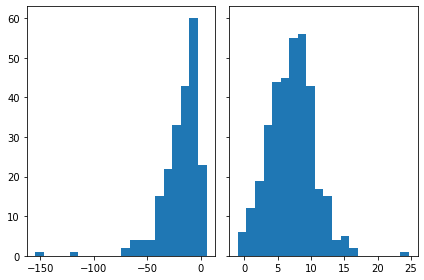

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
logreg.fit(X, y.values.flatten())
prediction=logreg.decision_function(X)

#Define positive and negative
cancer_index=y[y.Target==1].index
no_cancer_index=y[y.Target==0].index
cancer_prob=prediction[cancer_index]
no_cancer_prob=prediction[no_cancer_index]

#Histogram
n_bins = 20
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(no_cancer_prob, bins=n_bins)
axs[1].hist(cancer_prob, bins=n_bins)
plt.show()

For the visulization purpose we going to delete the outliners. We will cut off everything less than 20 and less than -20. We also use kernel density estimation (kde), a smooth line function that represent the histogram. 

In [100]:
cancer_prob=[i for i in cancer_prob if i<7.5]
no_cancer_prob=[i for i in no_cancer_prob if i > -5]

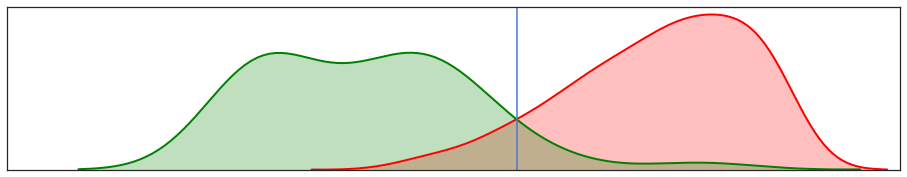

In [110]:
import seaborn as sns

plt.figure(figsize=(16,3))
sns.distplot(cancer_prob, hist=False, kde=True, 
              color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2,"shade": True})
sns.distplot(no_cancer_prob, hist=False, kde=True, 
              color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2,"shade": True})
plt.axvline(x=1.43)
plt.xlim(-10,10)
plt.xticks([])
plt.yticks([])
plt.show()

The blue line is the decision boundary. It divides the graph into 4 section:
* 1) Pure green: no cancer, True negative
* 2) Pure red: cancer, True positive
* 3) Mix left: has cancer but was detected as no cancer, false positive
* 4) Mix right: have no cancer but was detected as have cancer, false negative

Note that the model that we have right now look terrible. This judgement based on the mixed area which show that the model fail to distinguished a big portion of the sample. Out goal is also choose a model than can minimize this area.

In [15]:
# Normalize the Data
X = X.apply(lambda x : (x - x.min()) /(x.max() - x.min()),axis=0)

# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y.values.flatten(), random_state=0)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0])

In [22]:
from sklearn.metrics import roc_curve, auc

# Normalize the Data
X = X.apply(lambda x : (x - x.min()) /(x.max() - x.min()),axis=0) 
X_train, X_test, y_train, y_test = train_test_split(X, y.values.flatten(), random_state=0)

y_score = logreg.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

In [119]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.959748427672956


In [121]:
def ROC_curve(fpr,tpr):
    # Seaborn's beautiful styling
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

AUC: 0.959748427672956


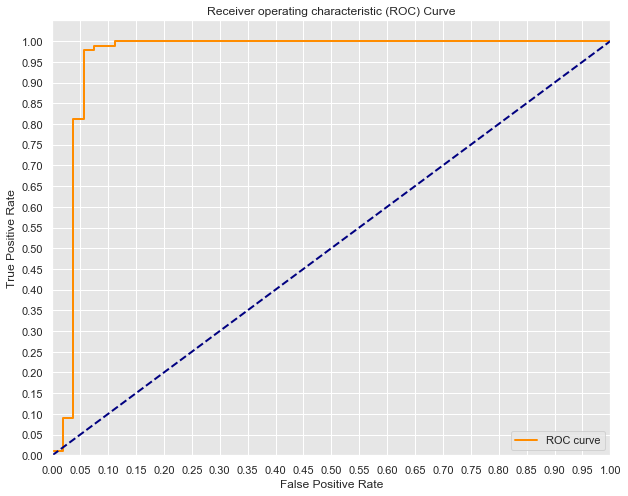

In [122]:
ROC_curve(fpr,tpr)

Observation:

Think about the scenario of this model: predicting brease cancer. If you tune the current model to have an 82% True Positive Rate, the False positive rate would approximately about 0.05. 

In [140]:
len(y_train)

426

In [160]:
fpr

array([0.        , 0.        , 0.01886792, 0.01886792, 0.03773585,
       0.03773585, 0.05660377, 0.05660377, 0.0754717 , 0.0754717 ,
       0.11320755, 0.11320755, 1.        ])

In [154]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

# fit model no training data
model_regressor = XGBRegressor()
model.fit(X_train.values, y_train)
model_classifier = XGBClassifier()
model_classifier.fit(X_train.values, y_train)

[12:51:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [158]:
y_predict=model_classifier.predict(X_test.values)
precision = precision_score(y_predict, y_test)
recall=recall_score(y_predict, y_test)

In [161]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict)

In [163]:
auc(fpr, tpr)

0.9755765199161426

AUC: 0.9755765199161426


Exception ignored in: <function Booster.__del__ at 0x129cb1ae8>
Traceback (most recent call last):
  File "/Users/huybui/anaconda3/lib/python3.7/site-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


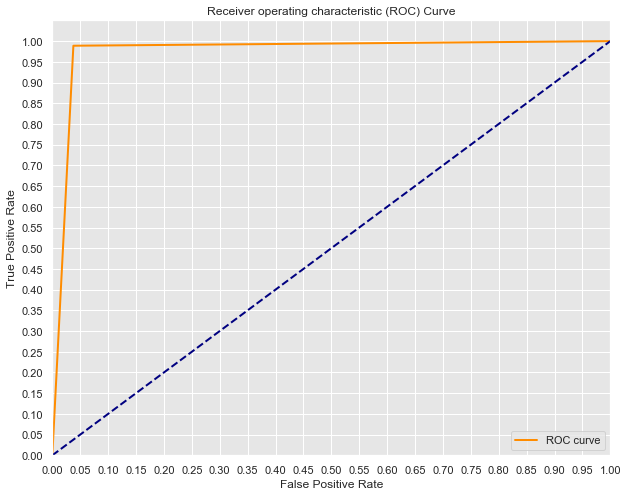

In [164]:
ROC_curve(fpr,tpr)